In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
!pip install torchsummary

from torchsummary import summary
from tqdm import tqdm
import tensorflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from torchvision import models

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Hyper-parameter
batch_size = 64
#  CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out
    

class InceptionModule(nn.Module):
    def __init__(self, in_channels, Ch1x1 , Ch3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
    
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, Ch3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, classes=10):
        super(InceptionNet, self).__init__()
        self.conv1 = ConvModule(in_channels=3, out_channels=96 , kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, Ch1x1=32 , Ch3x3=32)
        self.inception2 = InceptionModule(in_channels=64, Ch1x1=32 , Ch3x3=48)
        self.downsample1 = DownsampleModule(in_channels=80, Ch3x3=80)
        self.inception3 = InceptionModule(in_channels=160, Ch1x1=112 , Ch3x3=48)
        self.inception4 = InceptionModule(in_channels=160, Ch1x1=96 , Ch3x3=64)
        self.inception5 = InceptionModule(in_channels=160, Ch1x1=80 , Ch3x3=80)
        self.inception6 = InceptionModule(in_channels=160, Ch1x1=48 , Ch3x3=96)
        self.downsample2 = DownsampleModule(in_channels=144, Ch3x3=96)
        self.inception7 = InceptionModule(in_channels=240, Ch1x1=176 , Ch3x3=160)
        self.inception8 = InceptionModule(in_channels=336, Ch1x1=176 , Ch3x3=160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.inception1(out)
        out = self.inception2(out)
        out = self.downsample1(out)
        out = self.inception3(out)
        out = self.inception4(out)
        out = self.inception5(out)
        out = self.inception6(out)
        out = self.downsample2(out)
        out = self.inception7(out)
        out = self.inception8(out)
        out = self.mean_pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [24]:


class MLP1x512(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP1x512, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 3, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# summary(MLP1x512().to(device),(3,28,28))

In [12]:

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.lrn = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.lrn(x)
        return x

class AlexNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetSmall, self).__init__()
        self.conv1 = Conv(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = Conv(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        # two fully connected layers
        self.fc1 = nn.Linear(64 * 6 * 6, 384)
        self.fc2 = nn.Linear(384, 192)
        # 10-way linear layer is used for prediction
        self.fc3 = nn.Linear(192, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

model = AlexNetSmall().to(device)
summary(model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 13, 13]               0
 LocalResponseNorm-4           [-1, 64, 13, 13]               0
              Conv-5           [-1, 64, 13, 13]               0
            Conv2d-6           [-1, 64, 13, 13]         102,464
              ReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
 LocalResponseNorm-9             [-1, 64, 6, 6]               0
             Conv-10             [-1, 64, 6, 6]               0
           Linear-11                  [-1, 384]         885,120
             ReLU-12                  [-1, 384]               0
           Linear-13                  [-1, 192]          73,920
             ReLU-14                  [

In [11]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out
    

class InceptionModule(nn.Module):
    def __init__(self, in_channels, Ch1x1 , Ch3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
    
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, Ch3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, classes=10):
        super(InceptionNet, self).__init__()
        self.conv1 = ConvModule(in_channels=3, out_channels=96 , kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, Ch1x1=32 , Ch3x3=32)
        self.inception2 = InceptionModule(in_channels=64, Ch1x1=32 , Ch3x3=48)
        self.downsample1 = DownsampleModule(in_channels=80, Ch3x3=80)
        self.inception3 = InceptionModule(in_channels=160, Ch1x1=112 , Ch3x3=48)
        self.inception4 = InceptionModule(in_channels=160, Ch1x1=96 , Ch3x3=64)
        self.inception5 = InceptionModule(in_channels=160, Ch1x1=80 , Ch3x3=80)
        self.inception6 = InceptionModule(in_channels=160, Ch1x1=48 , Ch3x3=96)
        self.downsample2 = DownsampleModule(in_channels=144, Ch3x3=96)
        self.inception7 = InceptionModule(in_channels=240, Ch1x1=176 , Ch3x3=160)
        self.inception8 = InceptionModule(in_channels=336, Ch1x1=176 , Ch3x3=160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.inception1(out)
        out = self.inception2(out)
        out = self.downsample1(out)
        out = self.inception3(out)
        out = self.inception4(out)
        out = self.inception5(out)
        out = self.inception6(out)
        out = self.downsample2(out)
        out = self.inception7(out)
        out = self.inception8(out)
        out = self.mean_pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

cuda


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [63]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out
    

class InceptionModule(nn.Module):
    def __init__(self, in_channels, Ch1x1 , Ch3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
    
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, Ch3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, classes=10):
        super(InceptionNet, self).__init__()
        self.conv1 = ConvModule(in_channels=3, out_channels=96 , kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, Ch1x1=32 , Ch3x3=32)
        self.inception2 = InceptionModule(in_channels=64, Ch1x1=32 , Ch3x3=48)
        self.downsample1 = DownsampleModule(in_channels=80, Ch3x3=80)
        self.inception3 = InceptionModule(in_channels=160, Ch1x1=112 , Ch3x3=48)
        self.inception4 = InceptionModule(in_channels=160, Ch1x1=96 , Ch3x3=64)
        self.inception5 = InceptionModule(in_channels=160, Ch1x1=80 , Ch3x3=80)
        self.inception6 = InceptionModule(in_channels=160, Ch1x1=48 , Ch3x3=96)
        self.downsample2 = DownsampleModule(in_channels=144, Ch3x3=96)
        self.inception7 = InceptionModule(in_channels=240, Ch1x1=176 , Ch3x3=160)
        self.inception8 = InceptionModule(in_channels=336, Ch1x1=176 , Ch3x3=160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.inception1(out)
        out = self.inception2(out)
        out = self.downsample1(out)
        out = self.inception3(out)
        out = self.inception4(out)
        out = self.inception5(out)
        out = self.inception6(out)
        out = self.downsample2(out)
        out = self.inception7(out)
        out = self.inception8(out)
        out = self.mean_pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
def LabelCorruption(percentage,myloader):
    labels = myloader.dataset.targets[:]
    data = myloader.dataset.data
#     data = np.transpose(data,(0,3,1,2))
#     print(data.shape)
    num = int(len(labels)*percentage)
    idxes = []
#     print(num)
    # generate unique random index
    while len(idxes) < num:
        idx = np.random.randint(0,len(labels))
        if idx not in idxes:
            idxes.append(idx)
    # change the label of the index
    for idx in idxes:
        randomLabel = np.random.randint(0,10)
        while randomLabel == labels[idx]:
            randomLabel = np.random.randint(0,10)
        labels[idx] = randomLabel
    # corrupted dataset with new labels and original data with tranformtion same as original
    corrupted_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
    corrupted_dataset.data = data
    corrupted_dataset.targets = labels
    corrupted_loader = torch.utils.data.DataLoader(dataset=corrupted_dataset, batch_size=batch_size, shuffle=True)
    return corrupted_loader



In [27]:
def trainmodel(epochs=10,train_loader=train_loader,lr=0.001,corruption=0, modelName="Alexnet"):
    model = None
    if modelName == "Alexnet":
        model = AlexNetSmall()
    elif modelName == "Inception":
        model = InceptionNet()
    elif modelName == "MLP":
        model = MLP1x512()

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    if corruption>0:
        train_loader = LabelCorruption(percentage=corruption,myloader=train_loader)
    time1 = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
#             print(images.size())
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax.squeeze()).float().mean()
            running_acc += accuracy / len(train_loader)
            running_loss += loss / len(train_loader)
        train_loss.append(float(running_loss))
        train_acc.append(float(running_acc))
        # print("Epoch:" , epoch , "Train Loss" , running_loss , "Test Loss" , test_loss , "Train Accuracy" , running_acc , "Test Accuracy" , test_acc)
    time2 = time.time()
    timetaken = time2-time1
    return train_loss, train_acc , model,timetaken


In [30]:

# correctTrain_loss, correctTrain_acc , correctmodel,correcttimetaken = trainmodel(epochs=100,train_loader=train_loader,lr=0.001,modelName="Alexnet")


 38%|███▊      | 295/782 [00:06<00:10, 47.33it/s]


KeyboardInterrupt: 

In [44]:
# print(correctTrain_loss[-1])

tensor(0.2454, device='cuda:0', grad_fn=<AddBackward0>)



modelNames = ["Alexnet","Inception","MLP"]
modelDict = {}
for modelName in modelNames:
    percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    perTrainlosslst = []
    perTrainacclst = []
    pertimetakenlst = []
    permodellst = []
    for i in percentage:
        perTrainloss, perTrainacc , permodel,pertimetaken = trainmodel(epochs=10,train_loader=train_loader,lr=0.001,corruption=i,modelName=modelName)
        perTrainlosslst.append(perTrainloss)
        perTrainacclst.append(perTrainacc)
        pertimetakenlst.append(pertimetaken)
        permodellst.append(permodel)
        print("Model " , modelName , "Percentage of corruption: ",i,"Time taken: ",pertimetaken , "Train Accuracy: ",perTrainacc[-1] , "Train Loss: ",perTrainloss[-1])
    finallst = [perTrainlosslst,perTrainacclst,pertimetakenlst,permodellst]
    modelDict[modelName] = finallst


In [ ]:

modelNames = ["Alexnet","Inception","MLP"]
modelDict = {}
for modelName in modelNames:
    percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    perTrainlosslst = []
    perTrainacclst = []
    pertimetakenlst = []
    permodellst = []
    for i in percentage:
        perTrainloss, perTrainacc , permodel,pertimetaken = trainmodel(epochs=10,train_loader=train_loader,lr=0.001,corruption=i,modelName=modelName)
        perTrainlosslst.append(perTrainloss)
        perTrainacclst.append(perTrainacc)
        pertimetakenlst.append(pertimetaken)
        permodellst.append(permodel)
        print("Model " , modelName , "Percentage of corruption: ",i,"Time taken: ",pertimetaken , "Train Accuracy: ",perTrainacc[-1] , "Train Loss: ",perTrainloss[-1])
    # finallst = [perTrainlosslst,perTrainacclst,pertimetakenlst,permodellst]
    # modelDict[modelName] = finallst
    finaldict = {
        "TrainLosslst":perTrainlosslst,
        "TrainAccuracylst":perTrainacclst,
        "TimeTakenlst":pertimetakenlst,
        "Modellst":permodellst
    }
    modelDict[modelName] = finaldict








In [ ]:
# IncperTrainlosslst = []
# IncperTrainacclst = []
# Incpertimetakenlst = []
# percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# for i in percentage:
#     perTrainloss, perTrainacc , permodel,pertimetaken = trainmodel(epochs=100,train_loader=train_loader,lr=0.001,corruption=i,modelName="Inception")
#     IncperTrainlosslst.append(perTrainloss)
#     IncperTrainacclst.append(perTrainacc)
#     Incpertimetakenlst.append(pertimetaken)
#     print("Percentage of corruption: ",i,"Time taken: ",pertimetaken , "Train Accuracy: ",perTrainacc[-1] , "Train Loss: ",perTrainloss[-1])




In [ ]:
# MLPerTrainlosslst = []
# MLPperTrainacclst = []
# MLPpertimetakenlst = []
# percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# for i in percentage:
#     perTrainloss, perTrainacc , permodel,pertimetaken = trainmodel(epochs=100,train_loader=train_loader,lr=0.001,corruption=i,modelName="MLP")
#     MLPerTrainlosslst.append(perTrainloss)
#     MLPperTrainacclst.append(perTrainacc)
#     MLPpertimetakenlst.append(pertimetaken)
#     print("Percentage of corruption: ",i,"Time taken: ",pertimetaken , "Train Accuracy: ",perTrainacc[-1] , "Train Loss: ",perTrainloss[-1])




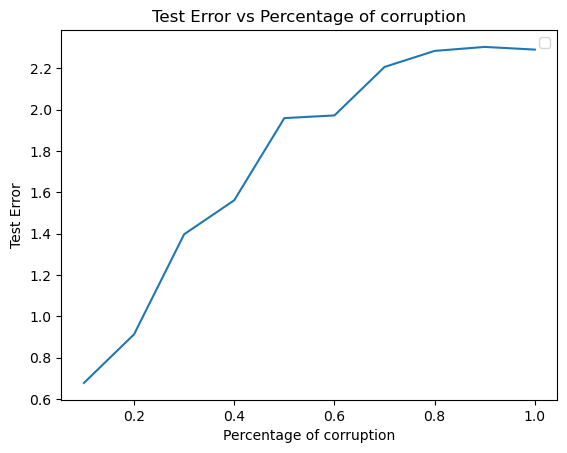

In [62]:

def plotTimegraph(modelDict):
    modelNames = modelDict.keys()
    for modelName in modelNames:
        timetakenlst = modelDict[modelName]["TimeTakenlst"]
        plt.plot(percentage,timetakenlst , label = modelName)
    plt.xlabel("Label corruption")
    plt.ylabel("Time taken to Overfit")
    plt.title("Time taken to Overfit vs Label corruption")
    plt.legend()
plotTimegraph(modelDict)


    

In [ ]:

def plottrainlossgraph(modelDict):
    modelNames = modelDict.keys()
    for modelName in modelNames:
        trainlosslst = modelDict[modelName]["TrainLosslst"]
        trainlosslst = [i[-1] for i in trainlosslst]
        plt.plot(percentage,trainlosslst , label = modelName)
    plt.xlabel("Label corruption")
    plt.ylabel("Train Loss")
    plt.title("Train Loss vs Label corruption")
    plt.legend()
plottrainlossgraph(modelDict)

In [ ]:
def testerror(model , test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    test_acc = 0.0
    for i, (images, labels) in enumerate(tqdm(test_loader)):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()
        test_acc += accuracy / len(test_loader)
        test_loss += loss / len(test_loader)
    return float(test_loss) , float(test_acc)

In [ ]:
def testErrorgraph(modelDict):
    modelNames = modelDict.keys()
    for modelName in modelNames:
        models = modelDict[modelName]["Modellst"]
        testlosslst = []
        for model in models:
            testloss , testacc = testerror(model,test_loader)
            testlosslst.append(testloss)
        plt.plot(percentage,testlosslst , label = modelName)
    plt.xlabel("Label corruption")
    plt.ylabel("Test Error")
    plt.title("Test Error vs Label corruption")
    plt.legend()
    
testErrorgraph(modelDict)